In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
from sklearn.datasets import load_svmlight_file
import os

In [28]:
# Load the dataset for one fold
def load_one_fold(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model 
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    if not hasattr(model, "booster_"):
        model.booster_ = model
    return model.booster_.feature_importance(importance_type=importance_type)

Number of unique queries: 6000


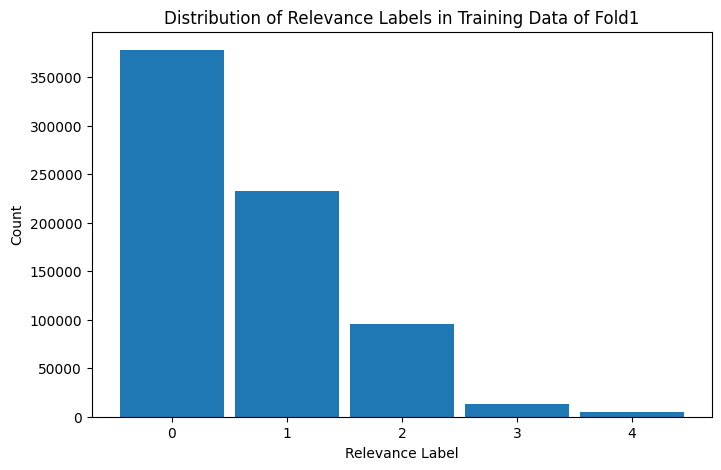

Number of unique queries: 6000


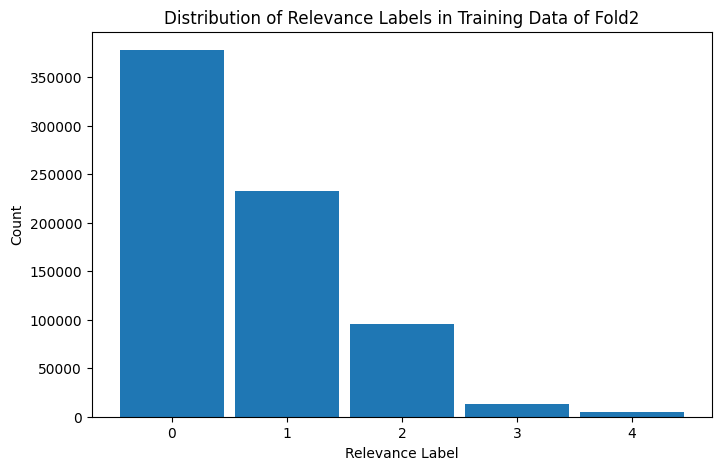

Number of unique queries: 6000


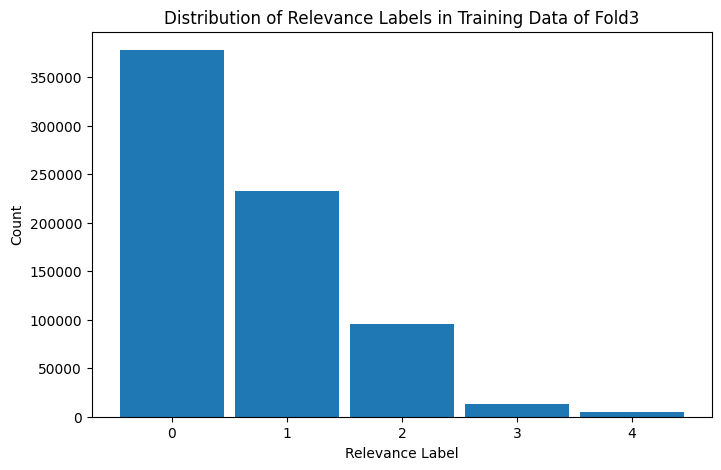

Number of unique queries: 6000


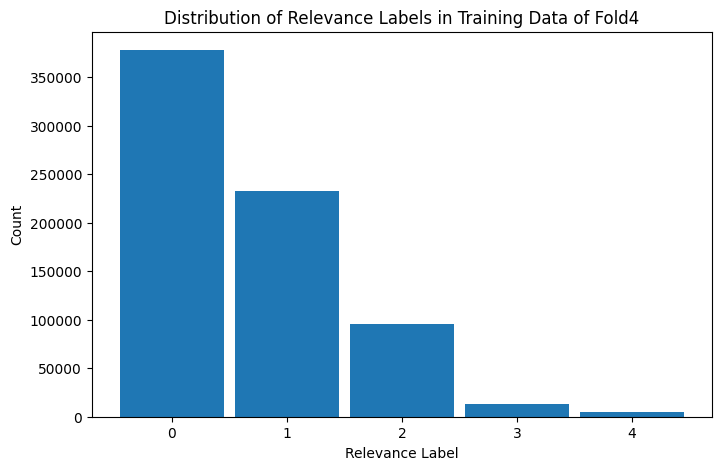

Number of unique queries: 6000


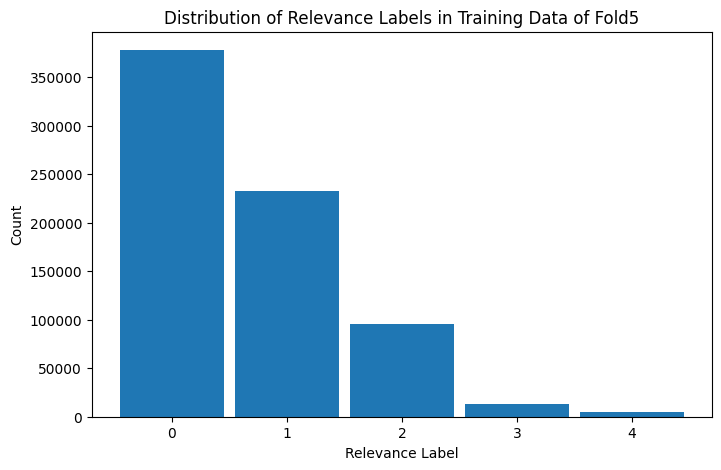

In [37]:
# Load first fold
datadir = "Project_3/web10kdata"
folds = ["Fold1","Fold2","Fold3","Fold4","Fold5"]
datapaths = [os.path.join(datadir, fold) for fold in folds]

for i in range(len(folds)):
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fold(datapaths[0] + "/")

    # Unique queries
    num_unique_queries = len(np.unique(qid_train))
    print(f"Number of unique queries: {num_unique_queries}")

    # Plot the distribution of relevance labels in the training set
    plt.figure(figsize=(8, 5))
    plt.hist(y_train, bins=np.arange(y_train.min(), y_train.max()+2)-0.5, rwidth=0.9)
    plt.xlabel("Relevance Label")
    plt.ylabel("Count")
    plt.title(f"Distribution of Relevance Labels in Training Data of {folds[i]}")
    plt.show()

In [25]:
def train_and_evaluate_fold(fold_path):
    # Load the fold
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fold(fold_path)
    
    # Prepare LightGBM datasets (group arrays are already computed in load_one_fol)
    train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
    test_data  = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)
    
    # Define parameters for lambdarank
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1
    }
    
    # Train the model (with early stopping on test set)
    model = lgb.train(params, 
                      train_data, 
                      num_boost_round=100,
                      valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=10)]
                      )
    
    # Evaluate nDCG at different positions
    ndcg3 = compute_ndcg_all(model, X_test, y_test, qid_test, k=3)
    ndcg5 = compute_ndcg_all(model, X_test, y_test, qid_test, k=5)
    ndcg10 = compute_ndcg_all(model, X_test, y_test, qid_test, k=10)
    
    print(f"Fold: {fold_path}")
    print("nDCG@3:", ndcg3)
    print("nDCG@5:", ndcg5)
    print("nDCG@10:", ndcg10)
    
    return model

# Loop over all folds and evaluate
for fold in datapaths:
    fold_path = os.path.join(fold, "")
    _ = train_and_evaluate_fold(fold_path)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25637
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 136
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.484571	valid_0's ndcg@2: 0.471408	valid_0's ndcg@3: 0.470753	valid_0's ndcg@4: 0.473569	valid_0's ndcg@5: 0.477409
Fold: Project_3/web10kdata/Fold1/
nDCG@3: 0.4510290463909536
nDCG@5: 0.4576642221444041
nDCG@10: 0.47531704205300174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25623
[LightGBM] [Info] Number of da

In [38]:
def print_top_features(model, top_n=5):
    # Get the full feature importance scores (using 'gain' as the importance type)
    importance_scores = get_feature_importance(model, importance_type='gain')
    # Get indices of the top n features (sorted descending)
    top_indices = np.argsort(importance_scores)[::-1][:top_n]
    print("Top", top_n, "features (indices) and their importance scores:")
    for idx in top_indices:
        print(f"Feature {idx}: Importance = {importance_scores[idx]:.0f}")

# Train model on each fold and print top features
for fold in datapaths:
    fold_path = os.path.join(fold, "")
    model = train_and_evaluate_fold(fold_path)
    print("Feature importance for fold:", fold)
    print_top_features(model, top_n=5)
    print("-" * 50)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.484571	valid_0's ndcg@2: 0.471408	valid_0's ndcg@3: 0.470753	valid_0's ndcg@4: 0.473569	valid_0's ndcg@5: 0.477409
Fold: Project_3/web10kdata/Fold1/
nDCG@3: 0.4510290463909536
nDCG@5: 0.4576642221444041
nDCG@10: 0.47531704205300174
Feature importance for fold: Project_3/web10kdata/Fold1
Top 5 features (indices) and their importance scores:
Feature 133: Importance = 50935
Feature 7: Importance = 10168
Feature 54: Importance = 8468
Feature 129: Importance = 6707
Feature 107: Importance = 6692
--------------------------------------------------
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	valid_0's ndcg@1: 0.473762	valid_0's ndcg@2: 0.459512	valid_0's ndcg@3: 0.457042	valid_0's ndcg@4: 0.457508	valid_0's ndcg@5: 0.461378
Fold: Project_3/web10kdata/Fold2/
nDCG@3: 0.4386336875643273
nDCG@5: 0.4427541732562348
nDCG@10:

In [ ]:
def train_lightgbm(X_train, y_train, group_train, X_test, y_test, group_test, qid_test, k_values=[3, 5, 10]):
    params = {
        'objective': 'lambdarank',
        'metric': 'ndcg',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1
    }

    train_data = lgb.Dataset(X_train, label=y_train, group=group_train)
    test_data = lgb.Dataset(X_test, label=y_test, group=group_test, reference=train_data)

    model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

    # Evaluate for multiple k-values
    results = {f"nDCG@{k}": compute_ndcg_all(model, X_test, y_test, qid_test, k) for k in k_values}
    return model, results

def reduce_features(X_train, X_test, features_to_remove):
    # Determine the full set of feature indices.
    all_features = np.arange(X_train.shape[1])
    # Determine the features to keep.
    features_to_keep = np.setdiff1d(all_features, features_to_remove)
    # Reduce the matrices to only these features.
    return X_train[:, features_to_keep], X_test[:, features_to_keep]

def experiment_feature_removal(fold_path):
    # Load fold data
    X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test = load_one_fold(fold_path)
    
    # Train initial model on full feature set
    model_full = train_and_evaluate_fold(fold_path)
    
    # Get full feature importance vector from the full model
    importance_scores = get_feature_importance(model_full, importance_type='gain')
    
    # --- Experiment 1: Remove the top 20 most important features ---
    top20 = np.argsort(importance_scores)[::-1][:20]
    X_train_reduced_top, X_test_reduced_top = reduce_features(X_train, X_test, top20)
    
    print("Experiment 1: Removing top 20 most important features")
    model_reduced_top, _ = train_lightgbm(X_train_reduced_top, y_train, group_train, 
                                          X_test_reduced_top, y_test, group_test, qid_test)
    ndcg_reduced_top = {k: compute_ndcg_all(model_reduced_top, X_test_reduced_top, y_test, qid_test, int(k.split('@')[1])) 
                        for k in ["nDCG@3", "nDCG@5", "nDCG@10"]}
    print("Results after removing top 20 features:", ndcg_reduced_top)
    
    # --- Experiment 2: Remove the bottom 60 least important features ---
    bottom60 = np.argsort(importance_scores)[:60]
    X_train_reduced_bottom, X_test_reduced_bottom = reduce_features(X_train, X_test, bottom60)
    
    print("Experiment 2: Removing bottom 60 least important features")
    model_reduced_bottom, _ = train_lightgbm(X_train_reduced_bottom, y_train, group_train, 
                                             X_test_reduced_bottom, y_test, group_test, qid_test)
    ndcg_reduced_bottom = {k: compute_ndcg_all(model_reduced_bottom, X_test_reduced_bottom, y_test, qid_test, int(k.split('@')[1])) 
                           for k in ["nDCG@3", "nDCG@5", "nDCG@10"]}
    print("Results after removing bottom 60 features:", ndcg_reduced_bottom)
    
# Run experiments on each fold
for fold in datapaths:
    fold_path = os.path.join(fold, "")
    print("Running feature removal experiments for fold:", fold)
    experiment_feature_removal(fold_path)
    print("=" * 100)

Evaluation Results: {'nDCG@3': 0.4515785465693818, 'nDCG@5': 0.45869806835849725, 'nDCG@10': 0.4767956851375214}
Running feature removal experiments for fold: Project_3/web10kdata/Fold1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.484571	valid_0's ndcg@2: 0.471408	valid_0's ndcg@3: 0.470753	valid_0's ndcg@4: 0.473569	valid_0's ndcg@5: 0.477409
Fold: Project_3/web10kdata/Fold1/
nDCG@3: 0.4510290463909536
nDCG@5: 0.4576642221444041
nDCG@10: 0.47531704205300174
Experiment 1: Removing top 20 most important features
Results after removing top 20 features: {'nDCG@3': 0.38248715051002774, 'nDCG@5': 0.3887523363979506, 'nDCG@10': 0.41357490508483663}
Experiment 2: Removing bottom 60 least important features
Results after removing bottom 60 features: {'nDCG@3': 0.4511498039296568, 'nDCG@5': 0.45760677655171783, 'nDCG@10': 0.4751698190670798}
Running feature removal experiments for fold: Project_3/web10kdata/Fold2
Traini